In [ ]:
!./setup.sh

In [48]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import polars as pl
from typing import Generator, Tuple

import torch
from torch.utils.data import Dataset, DataLoader

%load_ext autoreload
%autoreload 2
from scripts.lib import create_df, img_to_matrix
from scripts.augmentations import augmented

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Loading data files into Datasets

In [49]:
TRAIN_PATH = "../data/real_vs_fake/real-vs-fake/train/"
TEST_PATH = "../data/real_vs_fake/real-vs-fake/test/"
VAL_PATH = "../data/real_vs_fake/real-vs-fake/valid/"

In [50]:
train_df = create_df(TRAIN_PATH)
test_df = create_df(TEST_PATH)
val_df = create_df(VAL_PATH)

train_df.shape, test_df.shape, val_df.shape

((100000, 2), (20000, 2), (20000, 2))

In [75]:
class FacesDataset(Dataset):
    def __init__(self, data: pl.DataFrame, path: str) -> None:
        self.data = data
        self.path = path
    
    def __len__(self) -> int:
        return self.data.shape[0]
    
    def __getitem__(self, idx: int) -> Tuple[np.ndarray, int]:
        data = self.data.slice(idx, 1)
        face, label = data['file'].item(), data['label'].item()
        path = self.path + ('fake/' if label == 0 else 'real/')
        return img_to_matrix(path + face), label

In [76]:
train_loader = DataLoader(FacesDataset(train_df, TRAIN_PATH), shuffle=True)
val_loader = DataLoader(FacesDataset(val_df, VAL_PATH))
test_loader = DataLoader(FacesDataset(test_df, TEST_PATH))

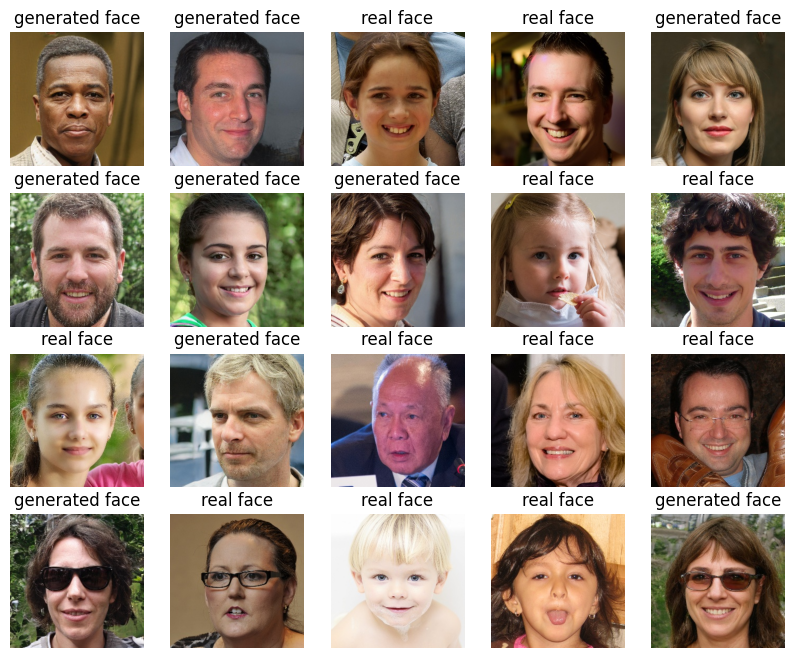

In [53]:
w, h = 8, 8
fig = plt.figure(figsize=(10, 8))
columns, rows = 5, 4

faces, labels = next(iter(train_loader))

for i in range(1, columns * rows + 1):
    fig.add_subplot(rows, columns, i)
    plt.title("generated face" if labels[i] == 0 else "real face")
    plt.imshow(faces[i].to(dtype=torch.uint8))
    plt.axis('off')

plt.show()